# SNSCRAPE

## tokenizer & stemmer

In [61]:
import pandas as pd
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer

In [62]:
media_results_csv = pd.read_csv('processed twitter data/media_results.csv')
creator_results_csv = pd.read_csv('processed twitter data/creator_results.csv')
general_results_csv = pd.read_csv('processed twitter data/general_results.csv')
vogue_results_csv = pd.read_csv('processed twitter data/vogue_results.csv')
compiler_results_csv = pd.read_csv('processed twitter data/compiler_results.csv')

In [63]:
media_results_list = media_results_csv['Processed'].tolist()
creator_results_list = creator_results_csv['Processed'].tolist()
general_results_list = general_results_csv['Processed'].tolist()
vogue_results_list = vogue_results_csv['Processed'].tolist()
compiler_results_list = compiler_results_csv['Processed'].tolist()

In [64]:
tokenizer = RegexpTokenizer(r'\w+')

media_words = []
creator_words = []
general_words = []
compiler_words = []
vogue_words = []

for tweet_text in media_results_list:
    if type(tweet_text) == type("string"):
        tokens = tokenizer.tokenize(tweet_text)
        media_words.append(tokens)

In [65]:
for tweet_text in creator_results_list:
    if type(tweet_text) == type("string"):
        tokens = tokenizer.tokenize(tweet_text)
        creator_words.append(tokens)

In [66]:
for tweet_text in general_results_list:
    if type(tweet_text) == type("string"):
        tokens = tokenizer.tokenize(tweet_text)
        general_words.append(tokens)

In [67]:
for tweet_text in compiler_results_list:
    if type(tweet_text) == type("string"):
        tokens = tokenizer.tokenize(tweet_text)
        compiler_words.append(tokens)

In [68]:
for tweet_text in vogue_results_list:
    if type(tweet_text) == type("string"):
        tokens = tokenizer.tokenize(tweet_text)
        vogue_words.append(tokens)

In [69]:
stopwords_LDA = ["go","m","pm","look","soon","start","let","yet","full","still","good","know","much", "well", 
                 "wait","try","thank","dm","lol","hit","put","ve","send","give","going","dude","stuff","get","got","l","p","10",
                 "co","gm","b","haha","work","many","hard","thing","make","next","come","fam","even","gt","1","2","3","4","5","6","7","8","9","pst",
                 "cet","est","wont","irl","100","u","x","via","hey","w","utc","worldhealthday2021","0","may","000","00","12","yes","30","24","et","1155",
                "50","20","im","15","e","7pm","vs","6pm","28","z","3pm","721","12pm","2nd","16","11","13","af","oh","17","thats","rt","30pm","8pm","21",
                 "theres","11am","17th","26","5pm","lp","youll","check","like","today","part","ever","need","every","lets","already","twitter",
                 "use","sure","something","please","tomorrow","us","see","across","pode","matic","way","fine","stay","nhs","within","might","10th",
                 "wanna","18","101","etc","per","says","came","sorry","thanks","including","another","set","able","back","left","become","gonna",
                 "comes","tonight","end","must","done","true","working","guys","never","seen","else","actually","retweet","really","200","23",
                "whose","ways","goo","led","appears","lil","till","wow","tweet","week","get","hope"]

In [70]:
for i in media_words:
    for j in i:
        if j in stopwords_LDA:
            i.remove(j)
print("done")

done


In [71]:
for i in creator_words:
    for j in i:
        if j in stopwords_LDA:
            i.remove(j)
print("done")

done


In [72]:
all_words = media_words+creator_words

In [73]:
for i in general_words:
    for j in i:
        if j in stopwords_LDA:
            i.remove(j)
print("done")

done


In [74]:
for i in compiler_words:
    for j in i:
        if j in stopwords_LDA:
            i.remove(j)
print("done")

done


In [75]:
for i in vogue_words:
    for j in i:
        if j in stopwords_LDA:
            i.remove(j)
print("done")

done


## LDA Topic Modelling 2

In [76]:
import nltk
import re
import numpy as np
import pandas as pd
from pprint import pprint
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy
import pyLDAvis
#import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline
import pyLDAvis.gensim as gensimvis

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

## media and creator combined LDA

In [77]:
# Build the bigram and trigram models
all_bigram = gensim.models.Phrases(all_words, min_count=5, threshold=100) # higher threshold fewer phrases.
all_trigram = gensim.models.Phrases(all_bigram[all_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
all_bigram_mod = gensim.models.phrases.Phraser(all_bigram)
all_trigram_mod = gensim.models.phrases.Phraser(all_trigram)

In [78]:
def make_bigrams6(texts):
    return [all_bigram_mod[doc] for doc in texts]

def make_trigrams6(texts):
    return [all_trigram_mod[all_bigram_mod[doc]] for doc in texts]

In [79]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [80]:
all_bigrams = make_bigrams6(all_words)

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

all_lemmatized = lemmatization(all_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [81]:
# Create Dictionary
all_id2word = corpora.Dictionary(all_lemmatized)

# Create Corpus
all_texts = all_lemmatized

# Term Document Frequency
all_corpus = [all_id2word.doc2bow(text) for text in all_texts]

In [82]:
all_topics = []
all_perplexity_score = []
all_coherence_score = []
all_vis = []

for i in range(3,7):
    all_lda_model = gensim.models.ldamodel.LdaModel(corpus=all_corpus,
                                           id2word=all_id2word,
                                           num_topics=i, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
    
    all_topics.append(all_lda_model.show_topics(num_topics=i,num_words=20))
    
    all_perplexity_score.append(all_lda_model.log_perplexity(all_corpus))
    
    coherence_model_lda = CoherenceModel(model=all_lda_model, texts=all_lemmatized, dictionary=all_id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    all_coherence_score.append(coherence_lda)
    
    pyLDAvis.enable_notebook()
    vis_i = gensimvis.prepare(all_lda_model, all_corpus, all_id2word)
    all_vis.append(vis_i)

C:\ProgramData\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


In [83]:
all_topics

[[(0,
   '0.035*"digital" + 0.025*"fashion" + 0.021*"love" + 0.018*"digitalax" + 0.015*"world" + 0.014*"want" + 0.013*"big" + 0.011*"brand" + 0.011*"time" + 0.010*"blockchain" + 0.010*"go" + 0.010*"ready" + 0.010*"get" + 0.009*"buy" + 0.009*"real" + 0.009*"digitalfashion" + 0.009*"right" + 0.007*"people" + 0.007*"collect" + 0.007*"read"'),
  (1,
   '0.040*"collection" + 0.030*"piece" + 0.017*"art" + 0.016*"available" + 0.014*"auction" + 0.012*"custom" + 0.011*"sell" + 0.011*"collectible" + 0.010*"owner" + 0.010*"new" + 0.010*"design" + 0.009*"mint" + 0.009*"item" + 0.009*"liftoff" + 0.009*"exclusive" + 0.008*"chain" + 0.008*"pendant" + 0.007*"launch" + 0.007*"mona" + 0.007*"support"'),
  (2,
   '0.043*"jewelry" + 0.028*"drop" + 0.017*"physical" + 0.014*"make" + 0.013*"future" + 0.011*"think" + 0.011*"community" + 0.010*"live" + 0.010*"space" + 0.010*"collector" + 0.009*"rarible" + 0.009*"begin" + 0.009*"cryptojeweler" + 0.008*"come" + 0.008*"join" + 0.008*"look" + 0.007*"start" + 0.007

In [84]:
all_vis[1]

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.270344  0.024403       1        1  29.729748
1     -0.152627 -0.199529       2        1  25.049719
0      0.026144 -0.069744       3        1  23.785829
2     -0.143861  0.244870       4        1  21.434705, topic_info=               Term        Freq       Total Category  logprob  loglift
5090        jewelry  569.000000  569.000000  Default  30.0000  30.0000
255            drop  438.000000  438.000000  Default  29.0000  29.0000
456           piece  452.000000  452.000000  Default  28.0000  28.0000
72          fashion  341.000000  341.000000  Default  27.0000  27.0000
112         digital  451.000000  451.000000  Default  26.0000  26.0000
...             ...         ...         ...      ...      ...      ...
2525   nftcollector   46.102445   47.100782   Topic4  -5.2750   1.5187
219        designer   39.264920   40.123875   Topic4  -5.4355   1.5185
5092  cryptojeweler  123.410670  126.584739   Topic4  -4.2903   1.5148
1071            far   43.182489   44.148910   Topic4  -5.3404   1.5180
262         auction  135.580463  202.113689   Topic4  -4.1963   1.1409

[163 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
3843      2  0.988523  appreciate
218       4  0.997012         art
2461      2  0.981148     article
208       2  0.991755      artist
262       2  0.326549     auction
...     ...       ...         ...
140       1  0.989409        wear
2286      3  0.990804        web3
669       3  0.980043         win
88        3  0.990408        work
79        3  0.993970       world

[152 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 1, 3])

In [85]:
#pyLDAvis.save_html(all_vis[2], 'all_lda_vis_5 topic.html')

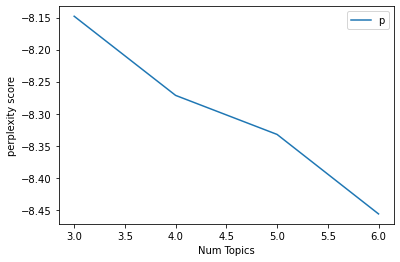

In [86]:
import matplotlib.pyplot as plt

limit=3+len(all_perplexity_score); start=3; step=1;
x = range(start, limit, step)
plt.plot(x, all_perplexity_score,label='perplexity')
plt.xlabel("Num Topics")
plt.ylabel("perplexity score")
plt.legend(("perplexity_values"), loc='best')
plt.show()

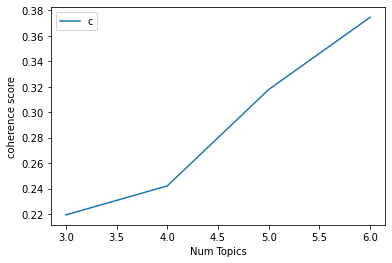

In [87]:
limit=3+len(all_perplexity_score); start=3; step=1;
x = range(start, limit, step)
plt.plot(x, all_coherence_score,label='coherence')
plt.xlabel("Num Topics")
plt.ylabel("coherence score")
plt.legend(("coherence"), loc='best')
plt.show()

In [88]:
all_lda_model_4 = gensim.models.ldamodel.LdaModel(corpus=all_corpus,
                                           id2word=all_id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [89]:
all_results_list = media_results_list + compiler_results_list

In [90]:
def format_topics_sentences(ldamodel=None, corpus=all_corpus, texts=all_results_list):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=all_lda_model_4, corpus=all_corpus, texts=all_results_list)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.3754,"drop, fashion, love, world, big, new, time, be...",launches frequent brands including gucci adida...
1,1,0.0,0.3928,"drop, fashion, love, world, big, new, time, be...",launches frequent brands like launching accord...
2,2,3.0,0.3671,"collection, physical, digitalax, sell, owner, ...",positioned physical influencer creator hub 1 2...
3,3,3.0,0.3252,"collection, physical, digitalax, sell, owner, ...",marketers discussed ways among topics digiday ...
4,4,3.0,0.3499,"collection, physical, digitalax, sell, owner, ...",positioned physical influencer creator hub 1 2...
5,5,0.0,0.4563,"drop, fashion, love, world, big, new, time, be...",latest hire styling track record daphne guinne...
6,6,0.0,0.3062,"drop, fashion, love, world, big, new, time, be...",delving skin market collection marries utility...
7,7,3.0,0.4984,"collection, physical, digitalax, sell, owner, ...",january dtc underwear brand meundies posted tw...
8,8,3.0,0.4727,"collection, physical, digitalax, sell, owner, ...",complete influencers product launches branded ...
9,9,3.0,0.3973,"collection, physical, digitalax, sell, owner, ...",register webinar january 26 1 p est discussion...


In [91]:
df_dominant_topic['Dominant_Topic'].value_counts()

3.0    1905
1.0     950
0.0     895
2.0     632
Name: Dominant_Topic, dtype: int64

In [92]:
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.6124,"drop, fashion, love, world, big, new, time, begin, go, pendant",fashion exec guide outline explain key technologies projects influential fashion across digital ...
1,1.0,0.6191,"piece, digital, available, want, custom, collectible, liftoff, exclusive, blockchain, mona",staytuned cant wait coming soon creation mode kind 8 888 unique hand drawn colorful vibrant insp...
2,2.0,0.5390,"jewelry, art, make, future, think, community, auction, collector, design, cryptojeweler",dutch dj diablo building massive literally could stand inside literally done says diablo put pri...
3,3.0,0.7002,"collection, physical, digitalax, sell, owner, live, space, rarible, mint, item",NaN


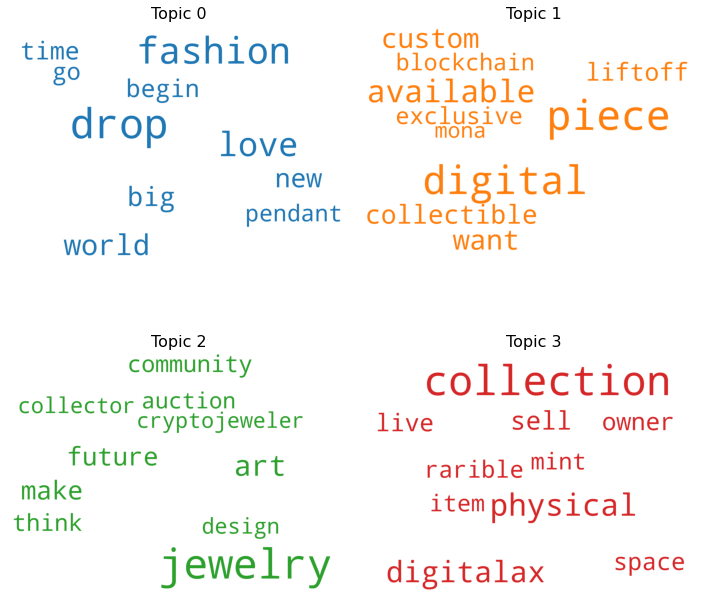

In [93]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stopwords_LDA,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=30,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = all_lda_model_4.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

## ALL - 5 topic model

In [76]:
# topic_1 = []
# topic_1_string = ''

# topic_2 = []
# topic_2_string = ''

# topic_3 = []
# topic_3_string = ''

# topic_4 = []
# topic_4_string = ''

# check1 = all_topics[2][0][1].split("\"")
# check1 = [s.rstrip("*").lstrip(" + ") for s in check1]

# check2 = all_topics[2][1][1].split("\"")
# check2 = [s.rstrip("*").lstrip(" + ") for s in check2]

# check3 = all_topics[2][2][1].split("\"")
# check3 = [s.rstrip("*").lstrip(" + ") for s in check3]

# check4 = all_topics[2][3][1].split("\"")
# check4 = [s.rstrip("*").lstrip(" + ") for s in check4]

In [77]:
# for i in range(20):
#     topic_1.append((check1[(i*2)+1],check1[i*2]))
#     topic_1_string += check1[(i*2)+1]
#     topic_1_string += " "
    
#     topic_2.append((check2[(i*2)+1],check2[i*2]))
#     topic_2_string += check2[(i*2)+1]
#     topic_2_string += " "
    
#     topic_3.append((check3[(i*2)+1],check3[i*2]))
#     topic_3_string += check3[(i*2)+1]
#     topic_3_string += " "
    
#     topic_4.append((check4[(i*2)+1],check4[i*2]))
#     topic_4_string += check4[(i*2)+1]
#     topic_4_string += " "
    
#     topic_5.append((check5[(i*2)+1],check5[i*2]))
#     topic_5_string += check5[(i*2)+1]
#     topic_5_string += " "

In [78]:
# print("These are the words for 5 topics")
# print("Perplexity score for 5-Topic model: ",all_perplexity_score[2])
# print("Coherence score for 5-Topic model: ",all_coherence_score[2])
# print(" ")
# print("Topic 1: ",topic_1_string)
# print(" ")
# print("Topic 2: ",topic_2_string)
# print(" ")
# print("Topic 3: ",topic_3_string)
# print(" ")
# print("Topic 4: ",topic_4_string)
# print(" ")
# print("Topic 5: ",topic_5_string)

## Bigram Data

In [94]:
#GENERAL
general_bigram = gensim.models.Phrases(general_words, min_count=5, threshold=100)
general_trigram = gensim.models.Phrases(general_bigram[general_words], threshold=100)  

general_bigram_mod = gensim.models.phrases.Phraser(general_bigram)
general_trigram_mod = gensim.models.phrases.Phraser(general_trigram)

print(general_trigram_mod[general_bigram_mod[general_words[0]]])

['digital', 'virtual', 'spaces', 'expanding_beyond', 'games', 'roblox', 'identify', 'gaming', 'platform', 'upcoming', 'many', 'brands', 'selling', 'digital', 'physical', 'versions', 'designs', 'gucci', 'adidas', 'ar']


In [95]:
#COMPILER
compiler_bigram = gensim.models.Phrases(compiler_words, min_count=5, threshold=100)
compiler_trigram = gensim.models.Phrases(compiler_bigram[compiler_words], threshold=100)  

compiler_bigram_mod = gensim.models.phrases.Phraser(compiler_bigram)
compiler_trigram_mod = gensim.models.phrases.Phraser(compiler_trigram)

print(compiler_trigram_mod[compiler_bigram_mod[compiler_words[0]]])

['artworks', 'display', 'personal', 'space', 'loving', 'colourful', 'groovy', 'digital', 'sculptures', 'artist', 'collabs', 'potions', 'collection', 'place', 'minting']


In [96]:
#VOGUE
vogue_bigram = gensim.models.Phrases(vogue_words, min_count=5, threshold=100)
vogue_trigram = gensim.models.Phrases(vogue_bigram[vogue_words], threshold=100)  

vogue_bigram_mod = gensim.models.phrases.Phraser(vogue_bigram)
vogue_trigram_mod = gensim.models.phrases.Phraser(vogue_trigram)

print(vogue_trigram_mod[vogue_bigram_mod[vogue_words[0]]])

['man', 'features', 'designs', 'modelled', 'animated', 'characteristic', 'peace', 'collection', 'available', 'sale', 'proceeds', 'save', 'children', 'ukraine']


In [97]:
#GENERAL
def make_bigrams3(texts):
    return [general_bigram_mod[doc] for doc in texts]
def make_trigrams3(texts):
    return [general_trigram_mod[general_bigram_mod[doc]] for doc in texts]

In [98]:
#COMPILER
def make_bigrams4(texts):
    return [compiler_bigram_mod[doc] for doc in texts]
def make_trigrams4(texts):
    return [compiler_trigram_mod[compiler_bigram_mod[doc]] for doc in texts]

In [99]:
#VOGUE
def make_bigrams5(texts):
    return [vogue_bigram_mod[doc] for doc in texts]
def make_trigrams5(texts):
    return [vogue_trigram_mod[vogue_bigram_mod[doc]] for doc in texts]

In [100]:
general_bigrams = make_bigrams3(general_words)
general_lemmatized = lemmatization(general_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [101]:
compiler_bigrams = make_bigrams4(compiler_words)
compiler_lemmatized = lemmatization(compiler_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [102]:
vogue_bigrams = make_bigrams5(vogue_words)
vogue_lemmatized = lemmatization(vogue_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [103]:
# Create Dictionary
general_id2word = corpora.Dictionary(general_lemmatized)
general_texts = general_lemmatized
general_corpus = [general_id2word.doc2bow(text) for text in general_texts]

In [104]:
compiler_id2word = corpora.Dictionary(compiler_lemmatized)
compiler_texts = compiler_lemmatized
compiler_corpus = [compiler_id2word.doc2bow(text) for text in compiler_texts]

In [105]:
vogue_id2word = corpora.Dictionary(vogue_lemmatized)
vogue_texts = vogue_lemmatized
vogue_corpus = [vogue_id2word.doc2bow(text) for text in vogue_texts]

## GENERAL LDA

In [ ]:
general_topics = []
general_perplexity_score = []
general_coherence_score = []
general_vis = []

for i in range(3,7):
    general_lda_model = gensim.models.ldamodel.LdaModel(corpus=general_corpus,
                                           id2word=general_id2word,
                                           num_topics=i, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
    
    general_topics.append(general_lda_model.show_topics(num_topics=i,num_words=30,formatted=True))
    
    general_perplexity_score.append(general_lda_model.log_perplexity(general_corpus))
    
    coherence_model_lda = CoherenceModel(model=general_lda_model, texts=general_lemmatized, dictionary=general_id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    general_coherence_score.append(coherence_lda)
    
    pyLDAvis.enable_notebook()
    vis_i = gensimvis.prepare(general_lda_model, general_corpus, general_id2word)
    general_vis.append(vis_i)

In [ ]:
general_topics

In [ ]:
general_vis[1]

In [ ]:
#general PERPLEXITY SCORE
import matplotlib.pyplot as plt

limit=3+len(general_perplexity_score); start=3; step=1;
x = range(start, limit, step)
plt.plot(x, general_perplexity_score,label='perplexity')
plt.xlabel("Num Topics")
plt.ylabel("perplexity score")
plt.legend(("perplexity_values"), loc='best')
plt.show()

In [ ]:
#general COHERENCE SCORE 
limit=3+len(general_perplexity_score); start=3; step=1;
x = range(start, limit, step)
plt.plot(x, general_coherence_score,label='coherence')
plt.xlabel("Num Topics")
plt.ylabel("coherence score")
plt.legend(("coherence"), loc='best')
plt.show()

In [130]:
general_lda_model_ = gensim.models.ldamodel.LdaModel(corpus=general_corpus,
                                           id2word=general_id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [132]:
def format_topics_sentences(ldamodel=None, corpus=general_corpus, texts=general_results_list):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=general_lda_model_4, corpus=general_corpus, texts=general_results_list)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.3754,"drop, fashion, love, world, big, new, time, be...",launches frequent brands including gucci adida...
1,1,0.0,0.3928,"drop, fashion, love, world, big, new, time, be...",launches frequent brands like launching accord...
2,2,3.0,0.3671,"collection, physical, digitalax, sell, owner, ...",positioned physical influencer creator hub 1 2...
3,3,3.0,0.3252,"collection, physical, digitalax, sell, owner, ...",marketers discussed ways among topics digiday ...
4,4,3.0,0.3499,"collection, physical, digitalax, sell, owner, ...",positioned physical influencer creator hub 1 2...
5,5,0.0,0.4563,"drop, fashion, love, world, big, new, time, be...",latest hire styling track record daphne guinne...
6,6,0.0,0.3062,"drop, fashion, love, world, big, new, time, be...",delving skin market collection marries utility...
7,7,3.0,0.4984,"collection, physical, digitalax, sell, owner, ...",january dtc underwear brand meundies posted tw...
8,8,3.0,0.4727,"collection, physical, digitalax, sell, owner, ...",complete influencers product launches branded ...
9,9,3.0,0.3973,"collection, physical, digitalax, sell, owner, ...",register webinar january 26 1 p est discussion...


In [135]:
df_dominant_topic['Dominant_Topic'].value_counts()

3.0    1905
1.0     950
0.0     895
2.0     632
Name: Dominant_Topic, dtype: int64

In [136]:
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.6124,"drop, fashion, love, world, big, new, time, begin, go, pendant",fashion exec guide outline explain key technologies projects influential fashion across digital ...
1,1.0,0.6191,"piece, digital, available, want, custom, collectible, liftoff, exclusive, blockchain, mona",NaN
2,2.0,0.5390,"jewelry, art, make, future, think, community, auction, collector, design, cryptojeweler",dutch dj diablo building massive literally could stand inside literally done says diablo put pri...
3,3.0,0.7002,"collection, physical, digitalax, sell, owner, live, space, rarible, mint, item",NaN


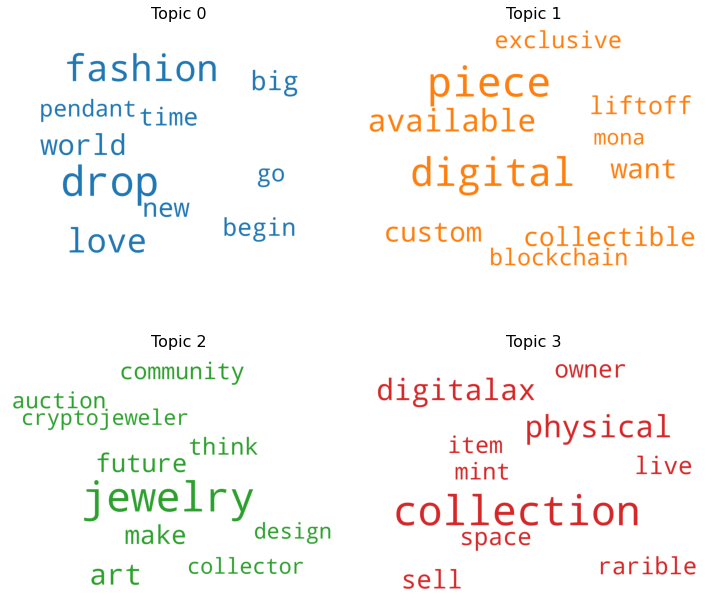

In [139]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stopwords_LDA,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=30,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = general_lda_model_4.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

## GENERAL - 8 topic model

In [ ]:
# topic_1 = []
# topic_1_string = ''

# topic_2 = []
# topic_2_string = ''

# topic_3 = []
# topic_3_string = ''

# topic_4 = []
# topic_4_string = ''

# topic_5 = []
# topic_5_string = ''

# topic_6 = []
# topic_6_string = ''

# topic_7 = []
# topic_7_string = ''

# topic_8 = []
# topic_8_string = ''

# check1 = all_topics[6][0][1].split("\"")
# check1 = [s.rstrip("*").lstrip(" + ") for s in check1]

# check2 = all_topics[6][1][1].split("\"")
# check2 = [s.rstrip("*").lstrip(" + ") for s in check2]

# check3 = all_topics[6][2][1].split("\"")
# check3 = [s.rstrip("*").lstrip(" + ") for s in check3]

# check4 = all_topics[6][3][1].split("\"")
# check4 = [s.rstrip("*").lstrip(" + ") for s in check4]

# check5 = all_topics[6][4][1].split("\"")
# check5 = [s.rstrip("*").lstrip(" + ") for s in check5]

# check6 = all_topics[6][5][1].split("\"")
# check6 = [s.rstrip("*").lstrip(" + ") for s in check6]

# check7 = all_topics[6][6][1].split("\"")
# check7 = [s.rstrip("*").lstrip(" + ") for s in check7]

# check8 = all_topics[6][7][1].split("\"")
# check8 = [s.rstrip("*").lstrip(" + ") for s in check8]

In [ ]:
# for i in range(20):
#     topic_1.append((check1[(i*2)+1],check1[i*2]))
#     topic_1_string += check1[(i*2)+1]
#     topic_1_string += " "
    
#     topic_2.append((check2[(i*2)+1],check2[i*2]))
#     topic_2_string += check2[(i*2)+1]
#     topic_2_string += " "
    
#     topic_3.append((check3[(i*2)+1],check3[i*2]))
#     topic_3_string += check3[(i*2)+1]
#     topic_3_string += " "
    
#     topic_4.append((check4[(i*2)+1],check4[i*2]))
#     topic_4_string += check4[(i*2)+1]
#     topic_4_string += " "
    
#     topic_5.append((check5[(i*2)+1],check5[i*2]))
#     topic_5_string += check5[(i*2)+1]
#     topic_5_string += " "
    
#     topic_6.append((check6[(i*2)+1],check6[i*2]))
#     topic_6_string += check6[(i*2)+1]
#     topic_6_string += " "
    
#     topic_7.append((check7[(i*2)+1],check7[i*2]))
#     topic_7_string += check7[(i*2)+1]
#     topic_7_string += " "
    
#     topic_8.append((check8[(i*2)+1],check8[i*2]))
#     topic_8_string += check8[(i*2)+1]
#     topic_8_string += " "

In [ ]:
# print("These are the words for 5 topics")
# print("Perplexity score for 8-Topic model: ",general_perplexity_score[6])
# print("Coherence score for 8-Topic model: ",general_coherence_score[6])
# print(" ")
# print("Topic 1: ",topic_1_string)
# print(" ")
# print("Topic 2: ",topic_2_string)
# print(" ")
# print("Topic 3: ",topic_3_string)
# print(" ")
# print("Topic 4: ",topic_4_string)
# print(" ")
# print("Topic 5: ",topic_5_string)
# print(" ")
# print("Topic 6: ",topic_6_string)
# print(" ")
# print("Topic 7: ",topic_7_string)
# print(" ")
# print("Topic 8: ",topic_8_string)

## COMPILER LDA

In [ ]:
compiler_topics = []
compiler_perplexity_score = []
compiler_coherence_score = []
compiler_vis = []

for i in range(3,7):
    compiler_lda_model = gensim.models.ldamodel.LdaModel(corpus=compiler_corpus,
                                           id2word=compiler_id2word,
                                           num_topics=i, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
    
    compiler_topics.append(compiler_lda_model.show_topics(num_topics=i,num_words=30,formatted=True))
    
    compiler_perplexity_score.append(compiler_lda_model.log_perplexity(compiler_corpus))
    
    coherence_model_lda = CoherenceModel(model=compiler_lda_model, texts=compiler_lemmatized, dictionary=compiler_id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    compiler_coherence_score.append(coherence_lda)
    
    pyLDAvis.enable_notebook()
    vis_i = gensimvis.prepare(compiler_lda_model, compiler_corpus, compiler_id2word)
    compiler_vis.append(vis_i)

In [ ]:
compiler_topics

In [ ]:
compiler_vis[2]

In [ ]:
#compiler PERPLEXITY SCORE
import matplotlib.pyplot as plt

limit=3+len(compiler_perplexity_score); start=3; step=1;
x = range(start, limit, step)
plt.plot(x, compiler_perplexity_score,label='perplexity')
plt.xlabel("Num Topics")
plt.ylabel("perplexity score")
plt.legend(("perplexity_values"), loc='best')
plt.show()

In [ ]:
#compiler COHERENCE SCORE 
limit=3+len(compiler_perplexity_score); start=3; step=1;
x = range(start, limit, step)
plt.plot(x, compiler_coherence_score,label='coherence')
plt.xlabel("Num Topics")
plt.ylabel("coherence score")
plt.legend(("coherence"), loc='best')
plt.show()

In [111]:
# pyLDAvis.save_html(all_vis[6], 'all_lda_vis7.html')

In [130]:
compiler_lda_model_4 = gensim.models.ldamodel.LdaModel(corpus=compiler_corpus,
                                           id2word=compiler_id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [132]:
def format_topics_sentences(ldamodel=None, corpus=compiler_corpus, texts=compiler_results_list):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=compiler_lda_model_4, corpus=compiler_corpus, texts=compiler_results_list)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.3754,"drop, fashion, love, world, big, new, time, be...",launches frequent brands including gucci adida...
1,1,0.0,0.3928,"drop, fashion, love, world, big, new, time, be...",launches frequent brands like launching accord...
2,2,3.0,0.3671,"collection, physical, digitalax, sell, owner, ...",positioned physical influencer creator hub 1 2...
3,3,3.0,0.3252,"collection, physical, digitalax, sell, owner, ...",marketers discussed ways among topics digiday ...
4,4,3.0,0.3499,"collection, physical, digitalax, sell, owner, ...",positioned physical influencer creator hub 1 2...
5,5,0.0,0.4563,"drop, fashion, love, world, big, new, time, be...",latest hire styling track record daphne guinne...
6,6,0.0,0.3062,"drop, fashion, love, world, big, new, time, be...",delving skin market collection marries utility...
7,7,3.0,0.4984,"collection, physical, digitalax, sell, owner, ...",january dtc underwear brand meundies posted tw...
8,8,3.0,0.4727,"collection, physical, digitalax, sell, owner, ...",complete influencers product launches branded ...
9,9,3.0,0.3973,"collection, physical, digitalax, sell, owner, ...",register webinar january 26 1 p est discussion...


In [135]:
df_dominant_topic['Dominant_Topic'].value_counts()

3.0    1905
1.0     950
0.0     895
2.0     632
Name: Dominant_Topic, dtype: int64

In [136]:
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.6124,"drop, fashion, love, world, big, new, time, begin, go, pendant",fashion exec guide outline explain key technologies projects influential fashion across digital ...
1,1.0,0.6191,"piece, digital, available, want, custom, collectible, liftoff, exclusive, blockchain, mona",NaN
2,2.0,0.5390,"jewelry, art, make, future, think, community, auction, collector, design, cryptojeweler",dutch dj diablo building massive literally could stand inside literally done says diablo put pri...
3,3.0,0.7002,"collection, physical, digitalax, sell, owner, live, space, rarible, mint, item",NaN


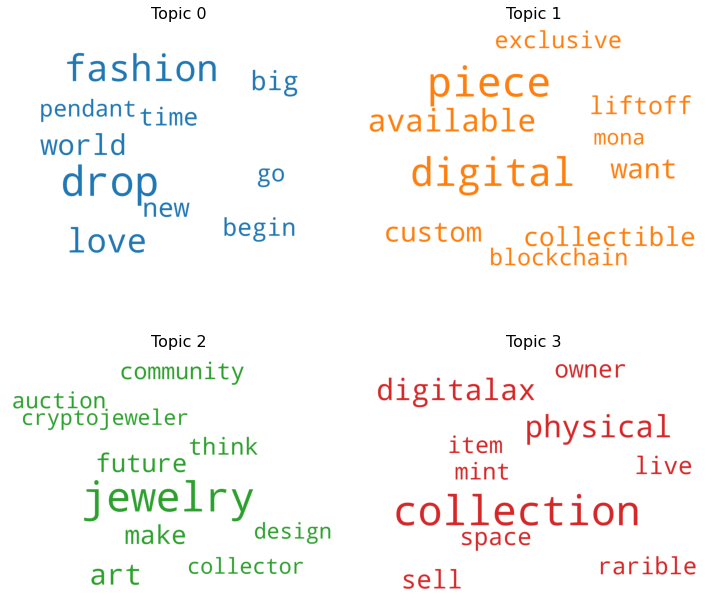

In [139]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stopwords_LDA,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=30,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = all_lda_model_4.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

## VOGUE LDA

In [ ]:
vogue_topics = []
vogue_perplexity_score = []
vogue_coherence_score = []
vogue_vis = []

for i in range(3,11):
    vogue_lda_model = gensim.models.ldamodel.LdaModel(corpus=vogue_corpus,
                                           id2word=vogue_id2word,
                                           num_topics=i, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
    
    vogue_topics.append(vogue_lda_model.show_topics(num_topics=i,num_words=20))
    
    vogue_perplexity_score.append(vogue_lda_model.log_perplexity(vogue_corpus))
    
    coherence_model_lda = CoherenceModel(model=vogue_lda_model, texts=vogue_lemmatized, dictionary=vogue_id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    vogue_coherence_score.append(coherence_lda)
    
    pyLDAvis.enable_notebook()
    vis_i = gensimvis.prepare(vogue_lda_model, vogue_corpus, vogue_id2word)
    vogue_vis.append(vis_i)

In [ ]:
vogue_topics

In [ ]:
vogue_vis[2]

In [ ]:
#vogue PERPLEXITY SCORE
import matplotlib.pyplot as plt

limit=3+len(vogue_perplexity_score); start=3; step=1;
x = range(start, limit, step)
plt.plot(x, vogue_perplexity_score,label='perplexity')
plt.xlabel("Num Topics")
plt.ylabel("perplexity score")
plt.legend(("perplexity_values"), loc='best')
plt.show()

In [ ]:
#vogue COHERENCE SCORE 
limit=3+len(vogue_perplexity_score); start=3; step=1;
x = range(start, limit, step)
plt.plot(x, vogue_coherence_score,label='coherence')
plt.xlabel("Num Topics")
plt.ylabel("coherence score")
plt.legend(("coherence"), loc='best')
plt.show()

In [ ]:
# pyLDAvis.save_html(all_vis[6], 'all_lda_vis7.html')

In [130]:
vogue_lda_model_4 = gensim.models.ldamodel.LdaModel(corpus=vogue_corpus,
                                           id2word=vogue_id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [132]:
def format_topics_sentences(ldamodel=None, corpus=vogue_corpus, texts=vogue_results_list):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=vogue_lda_model_4, corpus=vogue_corpus, texts=vogue_results_list)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.3754,"drop, fashion, love, world, big, new, time, be...",launches frequent brands including gucci adida...
1,1,0.0,0.3928,"drop, fashion, love, world, big, new, time, be...",launches frequent brands like launching accord...
2,2,3.0,0.3671,"collection, physical, digitalax, sell, owner, ...",positioned physical influencer creator hub 1 2...
3,3,3.0,0.3252,"collection, physical, digitalax, sell, owner, ...",marketers discussed ways among topics digiday ...
4,4,3.0,0.3499,"collection, physical, digitalax, sell, owner, ...",positioned physical influencer creator hub 1 2...
5,5,0.0,0.4563,"drop, fashion, love, world, big, new, time, be...",latest hire styling track record daphne guinne...
6,6,0.0,0.3062,"drop, fashion, love, world, big, new, time, be...",delving skin market collection marries utility...
7,7,3.0,0.4984,"collection, physical, digitalax, sell, owner, ...",january dtc underwear brand meundies posted tw...
8,8,3.0,0.4727,"collection, physical, digitalax, sell, owner, ...",complete influencers product launches branded ...
9,9,3.0,0.3973,"collection, physical, digitalax, sell, owner, ...",register webinar january 26 1 p est discussion...


In [135]:
df_dominant_topic['Dominant_Topic'].value_counts()

3.0    1905
1.0     950
0.0     895
2.0     632
Name: Dominant_Topic, dtype: int64

In [136]:
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.6124,"drop, fashion, love, world, big, new, time, begin, go, pendant",fashion exec guide outline explain key technologies projects influential fashion across digital ...
1,1.0,0.6191,"piece, digital, available, want, custom, collectible, liftoff, exclusive, blockchain, mona",NaN
2,2.0,0.5390,"jewelry, art, make, future, think, community, auction, collector, design, cryptojeweler",dutch dj diablo building massive literally could stand inside literally done says diablo put pri...
3,3.0,0.7002,"collection, physical, digitalax, sell, owner, live, space, rarible, mint, item",NaN


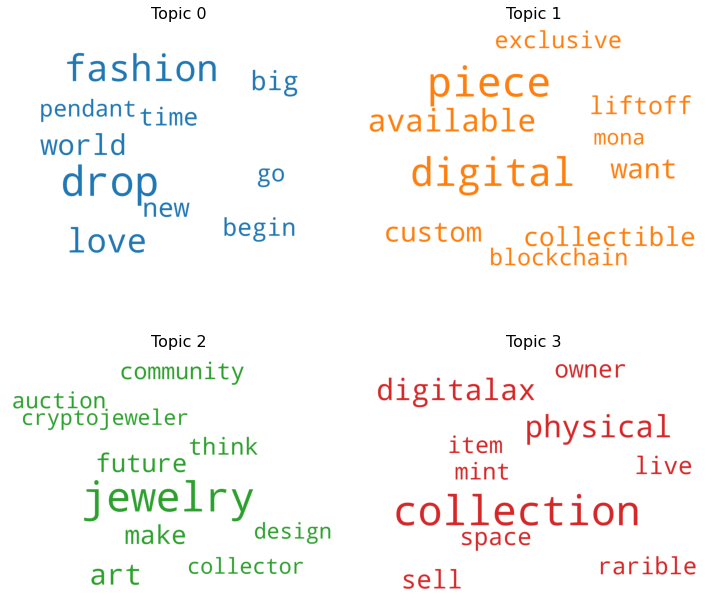

In [139]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stopwords_LDA,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=30,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = all_lda_model_4.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

## MEDIA, CREATOR PROCESSING

In [ ]:
# #MEDIA
# media_bigram = gensim.models.Phrases(media_words, min_count=5, threshold=100)
# media_trigram = gensim.models.Phrases(media_bigram[media_words], threshold=100)  

# media_bigram_mod = gensim.models.phrases.Phraser(media_bigram)
# media_trigram_mod = gensim.models.phrases.Phraser(media_trigram)

# print(media_trigram_mod[media_bigram_mod[media_words[0]]])

# #CREATOR
# creator_bigram = gensim.models.Phrases(creator_words, min_count=5, threshold=100)
# creator_trigram = gensim.models.Phrases(creator_bigram[creator_words], threshold=100)  

# creator_bigram_mod = gensim.models.phrases.Phraser(creator_bigram)
# creator_trigram_mod = gensim.models.phrases.Phraser(creator_trigram)

# print(creator_trigram_mod[creator_bigram_mod[creator_words[0]]])

In [ ]:
# #MEDIA
# def make_bigrams1(texts):
#     return [media_bigram_mod[doc] for doc in texts]
# def make_trigrams1(texts):
#     return [media_trigram_mod[media_bigram_mod[doc]] for doc in texts]

# #CREATOR
# def make_bigrams2(texts):
#     return [creator_bigram_mod[doc] for doc in texts]
# def make_trigrams2(texts):
#     return [creator_trigram_mod[creator_bigram_mod[doc]] for doc in texts]

In [ ]:
# #BIGRAMS
# media_bigrams = make_bigrams1(media_words)
# media_lemmatized = lemmatization(media_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

# creator_bigrams = make_bigrams2(creator_words)
# creator_lemmatized = lemmatization(creator_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

# print(media_lemmatized[:1])

In [ ]:
# media_id2word = corpora.Dictionary(media_lemmatized)
# creator_id2word = corpora.Dictionary(creator_lemmatized)

# media_texts = media_lemmatized
# creator_texts = creator_lemmatized

# media_corpus = [media_id2word.doc2bow(text) for text in media_texts]
# creator_corpus = [creator_id2word.doc2bow(text) for text in creator_texts]

## MEDIA LDA

In [ ]:
# media_topics = []
# media_perplexity_score = []
# media_coherence_score = []
# media_vis = []

# for i in range(3,11):
#     media_lda_model = gensim.models.ldamodel.LdaModel(corpus=media_corpus,
#                                            id2word=media_id2word,
#                                            num_topics=i, 
#                                            random_state=100,
#                                            update_every=1,
#                                            chunksize=100,
#                                            passes=10,
#                                            alpha='auto',
#                                            per_word_topics=True)
    
#     media_topics.append(media_lda_model.show_topics(num_topics=i,num_words=30,formatted=True))
    
#     media_perplexity_score.append(media_lda_model.log_perplexity(media_corpus))
    
#     coherence_model_lda = CoherenceModel(model=media_lda_model, texts=media_lemmatized, dictionary=media_id2word, coherence='c_v')
#     coherence_lda = coherence_model_lda.get_coherence()
#     media_coherence_score.append(coherence_lda)
    
#     pyLDAvis.enable_notebook()
#     vis_i = gensimvis.prepare(media_lda_model, media_corpus, media_id2word)
#     media_vis.append(vis_i)

In [ ]:
# media_topics

In [ ]:
# media_vis[0]

In [ ]:
# #MEDIA PERPLEXITY SCORE
# import matplotlib.pyplot as plt

# limit=3+len(media_perplexity_score); start=3; step=1;
# x = range(start, limit, step)
# plt.plot(x, media_perplexity_score,label='perplexity')
# plt.xlabel("Num Topics")
# plt.ylabel("perplexity score")
# plt.legend(("perplexity_values"), loc='best')
# plt.show()

In [ ]:
# # MEDIA COHERENCE SCORE 
# limit=3+len(media_perplexity_score); start=3; step=1;
# x = range(start, limit, step)
# plt.plot(x, media_coherence_score,label='coherence')
# plt.xlabel("Num Topics")
# plt.ylabel("coherence score")
# plt.legend(("coherence"), loc='best')
# plt.show()

## CREATOR LDA

In [ ]:
# creator_topics = []
# creator_perplexity_score = []
# creator_coherence_score = []
# creator_vis = []

# for i in range(3,11):
#     creator_lda_model = gensim.models.ldamodel.LdaModel(corpus=creator_corpus,
#                                            id2word=creator_id2word,
#                                            num_topics=i, 
#                                            random_state=100,
#                                            update_every=1,
#                                            chunksize=100,
#                                            passes=10,
#                                            alpha='auto',
#                                            per_word_topics=True)
    
#     creator_topics.append(creator_lda_model.show_topics(num_topics=i,num_words=30,formatted=True))
    
#     creator_perplexity_score.append(creator_lda_model.log_perplexity(creator_corpus))
    
#     coherence_model_lda = CoherenceModel(model=creator_lda_model, texts=creator_lemmatized, dictionary=creator_id2word, coherence='c_v')
#     coherence_lda = coherence_model_lda.get_coherence()
#     creator_coherence_score.append(coherence_lda)
    
#     pyLDAvis.enable_notebook()
#     vis_i = gensimvis.prepare(creator_lda_model, creator_corpus, creator_id2word)
#     creator_vis.append(vis_i)

In [ ]:
# creator_topics

In [ ]:
# creator_vis[0]

In [ ]:
# #CREATOR PERPLEXITY SCORE
# import matplotlib.pyplot as plt

# limit=3+len(creator_perplexity_score); start=3; step=1;
# x = range(start, limit, step)
# plt.plot(x, creator_perplexity_score,label='perplexity')
# plt.xlabel("Num Topics")
# plt.ylabel("perplexity score")
# plt.legend(("perplexity_values"), loc='best')
# plt.show()

In [ ]:
# #CREATOR COHERENCE SCORE 
# limit=3+len(creator_perplexity_score); start=3; step=1;
# x = range(start, limit, step)
# plt.plot(x, creator_coherence_score,label='coherence')
# plt.xlabel("Num Topics")
# plt.ylabel("coherence score")
# plt.legend(("coherence"), loc='best')
# plt.show()